<a href="https://colab.research.google.com/github/jaydent22/661-final-project/blob/main/gpt-neo/661_GPT_Neo_CARER_CoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-Neo CARER Chain of Thought

This notebook will use zero-shot chain-of-thought prompting on a pretrained GPT-Neo model to measure its performance on the Contextualized Affect Representations for Emotion Recognition dataset. Performance of human-generated and ChatGPT-generated prompts will be compared.

## Setup

In [ ]:
!pip install transformers datasets pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from transformers import GPT2TokenizerFast, GPTNeoForCausalLM, GPTNeoForQuestionAnswering
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from time import time
import random

In [ ]:
cuda = torch.device('cuda')

In [ ]:
model_id = "EleutherAI/gpt-neo-2.7B"

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

In [ ]:
model = GPTNeoForCausalLM.from_pretrained(model_id)
model.to(cuda)
model.eval()
print(model)

model.safetensors:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2560)
    (wpe): Embedding(2048, 2560)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-31): 32 x GPTNeoBlock(
        (ln_1): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (v_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (q_proj): Linear(in_features=2560, out_features=2560, bias=False)
            (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
          )
        )
        (ln_2): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2560, out_features=10240, bias=True)
          (c_proj)

In [ ]:
def predict_sentiment(text):
  inputs = tokenizer(wrap_sentence(text), truncation=True, return_tensors="pt").to(cuda)
  output = model.generate(
      **inputs,
      max_new_tokens=60,
      num_return_sequences=1,
      pad_token_id=tokenizer.eos_token_id,
      # no_repeat_ngram_size=2,
      # repetition_penalty=1.7,
      # do_sample=True,
      # temperature=0.2,
      # top_k=50,
      # top_p=0.9,
  )
  return tokenizer.decode(output[0], skip_special_tokens=True)

## Dataset

In [ ]:
dataset = load_dataset("dair-ai/emotion")
print(type(dataset))

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

<class 'datasets.dataset_dict.DatasetDict'>


In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [ ]:
# baseline CARER models used test dataset for inference
for i, val in enumerate(dataset['test']):
    print(val)
    if i == 10:
        break

{'text': 'im feeling rather rotten so im not very ambitious right now', 'label': 0}
{'text': 'im updating my blog because i feel shitty', 'label': 0}
{'text': 'i never make her separate from me because i don t ever want her to feel like i m ashamed with her', 'label': 0}
{'text': 'i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived', 'label': 1}
{'text': 'i was feeling a little vain when i did this one', 'label': 0}
{'text': 'i cant walk into a shop anywhere where i do not feel uncomfortable', 'label': 4}
{'text': 'i felt anger when at the end of a telephone call', 'label': 3}
{'text': 'i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia', 'label': 1}
{'text': 'i like to have the same breathless feeling as a reader eager to see what will happen next', 'labe

In [ ]:
len(tokenizer("""
Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]""")['input_ids'])

72

In [ ]:
label_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

In [ ]:
emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise', 'invalid']

## Inference

The prompt examples have been selected from the training set in advance.

### All examples

In [ ]:
def wrap_sentence(text):
  return f"""
Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: im feel alone and i dont know how to cope
Reasoning:
Let's think step by step. The word "alone" implies sadness, and no other sentimental words follow. Therefore, the sentence expresses sadness.
Emotion: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i didnt want to tell him because arun has these single line solutions to all my problems taht leave me feeling extremely dissatisfied
Reasoning:
Let's think step by step. The phrase "single line solutions", followed by the negative word "dissatisfied", implies dislike and anger for the situation. The overall tone is negative. Therefore, the closest emotion is anger.
Emotion: anger

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i just had this feeling that i liked him more
Reasoning:
Let's think step by step. The word "liked" expresses fondness. The following word "more" intensifies this fondness. Therefore, the sentence expresses love.
Emotion: love

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i watch her silently feeling dazed from my memory loss
Reasoning:
Let's think step by step. The word "dazed" implies confusion or bewilderment, and the sentence contains mixed tones, both positive and negative. Therefore, the sentence expresses surprise.
Emotion: surprise

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i realized that when i let my mind race and i start to feel restless i get the desire to smoke
Reasoning:
Let's think step by step. The word "restless" implies anxiety and uneasiness. Smoking is often used as a method of stress relief. Therefore, the sentence expresses fear.
Emotion: fear

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i feel cool calm and collected
Reasoning:
Let's think step by step. The words "cool", "calm", and "collected" express positive emotions. No negative words follow, so the sentence has an overall positive tone. The closest emotion is joy. Therefore, the sentence expresses joy.
Emotion: joy

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: {text}
Reasoning:
Let's think step by step.
"""

In [ ]:
text = "what a great day"
print(predict_sentiment(text))


Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: im feel alone and i dont know how to cope
Reasoning:
Let's think step by step. The word "alone" implies sadness, and no other sentimental words follow. Therefore, the sentence expresses sadness.
Emotion: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i didnt want to tell him because arun has these single line solutions to all my problems taht leave me feeling extremely dissatisfied
Reasoning:
Let's t

In [ ]:
pred_emots = []
true_emots = []
for i in range(5):
  rand = random.randint(0, len(dataset["test"]))
  text = dataset["test"][rand]
  print(text['text'])
  emot = label_map[text['label']]
  print(f"True label: {emot}")
  true_emots.append(emot)
  output = predict_sentiment(text['text'])
  print(output)
  pred_emots.append(output.split("Emotion: ")[-1].split("\n")[0])
  print("------------------------------------------------")

i feel so unloved without you next to me but when im with you
True label: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: im feel alone and i dont know how to cope
Reasoning:
Let's think step by step. The word "alone" implies sadness, and no other sentimental words follow. Therefore, the sentence expresses sadness.
Emotion: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i didnt want to tell him because arun has these single line solutions 

In [ ]:
print(true_emots)
print(pred_emots)

['sadness', 'joy', 'anger', 'anger', 'fear']
['sadness', 'priority', 'lightness', 'annoyance', 'indecision']


In [ ]:
len(dataset['test'])

2000

In [ ]:
t0 = time()
all_preds = []
all_labels = []
for i in range(len(dataset['test'])):
  text = dataset["test"][i]
  sent = label_map[text['label']]
  all_labels.append(sent)
  output = predict_sentiment(text['text'])
  j = -1
  emot = output.split("Emotion: ")[j].split("\n")[0]
  while emot.startswith("["):
    j -= 1
    emot = output.split("Emotion: ")[j].split("\n")[0]
  all_preds.append(emot)
  # all_preds.append(output.split("Emotion: ")[-1].split("\n")[0])
  if i % 100 == 99:
    print(f"Processed {i+1} reviews")
    print(f"Time elapsed: {time()-t0: .3f}s")

Processed 100 reviews
Time elapsed:  224.744s
Processed 200 reviews
Time elapsed:  449.037s
Processed 300 reviews
Time elapsed:  675.150s
Processed 400 reviews
Time elapsed:  900.977s
Processed 500 reviews
Time elapsed:  1126.052s
Processed 600 reviews
Time elapsed:  1351.170s
Processed 700 reviews
Time elapsed:  1575.384s
Processed 800 reviews
Time elapsed:  1800.202s
Processed 900 reviews
Time elapsed:  2024.765s
Processed 1000 reviews
Time elapsed:  2249.132s
Processed 1100 reviews
Time elapsed:  2474.525s
Processed 1200 reviews
Time elapsed:  2699.311s
Processed 1300 reviews
Time elapsed:  2924.442s
Processed 1400 reviews
Time elapsed:  3148.306s
Processed 1500 reviews
Time elapsed:  3371.327s
Processed 1600 reviews
Time elapsed:  3594.645s
Processed 1700 reviews
Time elapsed:  3817.394s
Processed 1800 reviews
Time elapsed:  4040.944s
Processed 1900 reviews
Time elapsed:  4264.700s
Processed 2000 reviews
Time elapsed:  4488.208s


In [ ]:
reverse_map = {emotion: value for value, emotion in label_map.items()}

preds = np.array([reverse_map.get(x, 6) for x in all_preds])
labels = np.array([reverse_map[x] for x in all_labels])

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.75      0.28      0.41       581
           1       0.57      0.11      0.18       695
           2       0.46      0.19      0.27       159
           3       0.79      0.23      0.35       275
           4       0.51      0.31      0.39       224
           5       0.08      0.39      0.13        66
           6       0.00      0.00      0.00         0

    accuracy                           0.21      2000
   macro avg       0.45      0.22      0.25      2000
weighted avg       0.62      0.21      0.30      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


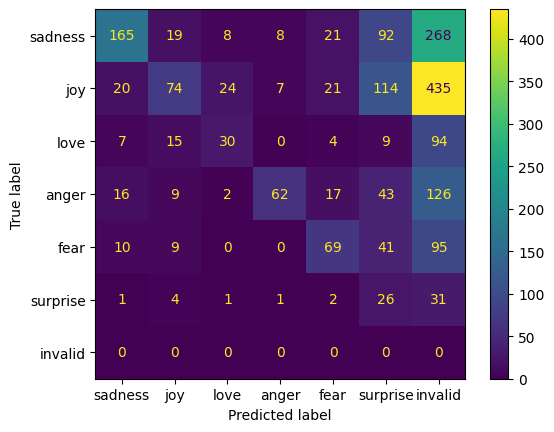

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot()
plt.show()

Text(0, 0.5, 'Accuracy (%)')

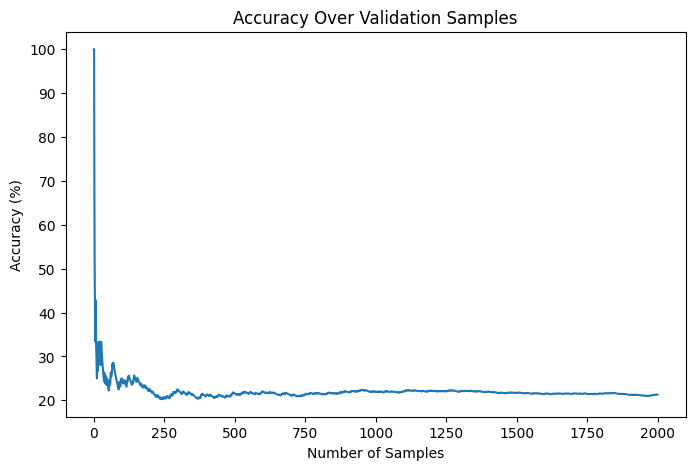

In [ ]:
accuracies = np.cumsum(np.array(all_labels) == np.array(all_preds)) / np.arange(1, len(all_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")

### Only keep a few examples (i.e., not all classes have an example)

In [ ]:
def wrap_sentence(text):
  return f"""
Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output only one word, and it must be one of the following: joy, fear, anger, surprise, sadness, or disgust. Do not output anything else.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: im feel alone and i dont know how to cope
Reasoning:
Let's think step by step. The word "alone" implies sadness, and no other sentimental words follow. Therefore, the sentence expresses sadness.
Emotion: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output only one word, and it must be one of the following: joy, fear, anger, surprise, sadness, or disgust. Do not output anything else.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i just had this feeling that i liked him more
Reasoning:
Let's think step by step. The word "liked" expresses fondness. The following word "more" intensifies this fondness. Therefore, the sentence expresses love.
Emotion: love

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output only one word, and it must be one of the following: joy, fear, anger, surprise, sadness, or disgust. Do not output anything else.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: i feel cool calm and collected
Reasoning:
Let's think step by step. The words "cool", "calm", and "collected" express positive emotions. No negative words follow, so the sentence has an overall positive tone. The closest emotion is joy. Therefore, the sentence expresses joy.
Emotion: joy

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output only one word, and it must be one of the following: joy, fear, anger, surprise, sadness, or disgust. Do not output anything else.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: {text}
Reasoning:
Let's think step by step.
"""

In [ ]:
text = "what a great day"
print(predict_sentiment(text))


Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output only one word, and it must be one of the following: joy, fear, anger, surprise, sadness, or disgust. Do not output anything else.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: im feel alone and i dont know how to cope
Reasoning:
Let's think step by step. The word "alone" implies sadness, and no other sentimental words follow. Therefore, the sentence expresses sadness.
Emotion: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output only one word, and it must be one of the following: joy, fear, anger, surprise, sadness, or disgust. D

In [ ]:
pred_emots = []
true_emots = []
for i in range(5):
  rand = random.randint(0, len(dataset["test"])-1)
  text = dataset["test"][rand]
  print(text['text'])
  emot = label_map[text['label']]
  print(f"True label: {emot}")
  true_emots.append(emot)
  output = predict_sentiment(text['text'])
  print(output)
  pred_emots.append(output.split("Emotion: ")[-1].split("\n")[0])
  print("------------------------------------------------")

i would call success and i was feeling pretty depressed about the state of clothes
True label: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output only one word, and it must be one of the following: joy, fear, anger, surprise, sadness, or disgust. Do not output anything else.
State the emotion in the form
Emotion: [sadness, joy, love, anger, fear, surprise]

Sentence: im feel alone and i dont know how to cope
Reasoning:
Let's think step by step. The word "alone" implies sadness, and no other sentimental words follow. Therefore, the sentence expresses sadness.
Emotion: sadness

Read the sentence and classify its emotion into one of the following categories: sadness, joy, love, anger, fear, surprise
First, identify the emotional words.
Then, determine the overall emotion expressed in the sentence.
Output

In [ ]:
print(true_emots)
print(pred_emots)

['sadness', 'joy', 'joy', 'joy', 'anger']
['wish', 'joy', 'feeling', 'joy', 'stubbornness']


In [ ]:
t0 = time()
all_preds = []
all_labels = []
for i in range(len(dataset['test'])):
  text = dataset["test"][i]
  sent = label_map[text['label']]
  all_labels.append(sent)
  output = predict_sentiment(text['text'])
  j = -1
  emot = output.split("Emotion: ")[j].split("\n")[0]
  while emot.startswith("["):
    j -= 1
    emot = output.split("Emotion: ")[j].split("\n")[0]
  all_preds.append(emot)
  # all_preds.append(output.split("Emotion: ")[-1].split("\n")[0])
  if i % 100 == 99:
    print(f"Processed {i+1} reviews")
    print(f"Time elapsed: {time()-t0: .3f}s")

Processed 100 reviews
Time elapsed:  218.320s
Processed 200 reviews
Time elapsed:  436.728s
Processed 300 reviews
Time elapsed:  654.915s
Processed 400 reviews
Time elapsed:  872.161s
Processed 500 reviews
Time elapsed:  1092.253s
Processed 600 reviews
Time elapsed:  1310.813s
Processed 700 reviews
Time elapsed:  1527.552s
Processed 800 reviews
Time elapsed:  1743.538s
Processed 900 reviews
Time elapsed:  1959.112s
Processed 1000 reviews
Time elapsed:  2175.306s
Processed 1100 reviews
Time elapsed:  2391.479s
Processed 1200 reviews
Time elapsed:  2607.616s
Processed 1300 reviews
Time elapsed:  2823.430s
Processed 1400 reviews
Time elapsed:  3040.767s
Processed 1500 reviews
Time elapsed:  3258.406s
Processed 1600 reviews
Time elapsed:  3475.158s
Processed 1700 reviews
Time elapsed:  3691.845s
Processed 1800 reviews
Time elapsed:  3908.943s
Processed 1900 reviews
Time elapsed:  4127.728s
Processed 2000 reviews
Time elapsed:  4345.775s


In [ ]:
reverse_map = {emotion: value for value, emotion in label_map.items()}

preds = np.array([reverse_map.get(x, 6) for x in all_preds])
labels = np.array([reverse_map[x] for x in all_labels])

print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.63      0.33      0.43       581
           1       0.54      0.16      0.25       695
           2       0.36      0.23      0.28       159
           3       0.62      0.19      0.29       275
           4       0.61      0.18      0.28       224
           5       0.35      0.09      0.14        66
           6       0.00      0.00      0.00         0

    accuracy                           0.22      2000
   macro avg       0.44      0.17      0.24      2000
weighted avg       0.56      0.22      0.31      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


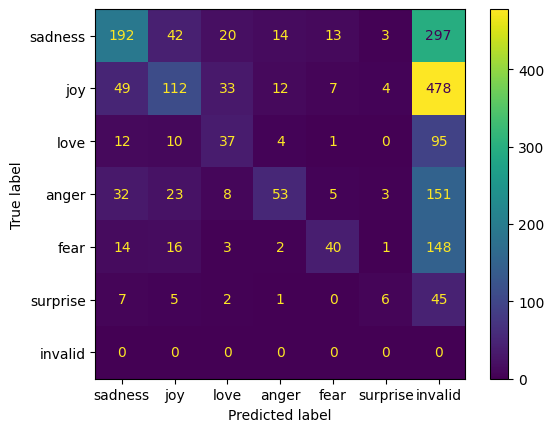

In [ ]:
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotions)
disp.plot()
plt.show()

Text(0, 0.5, 'Accuracy (%)')

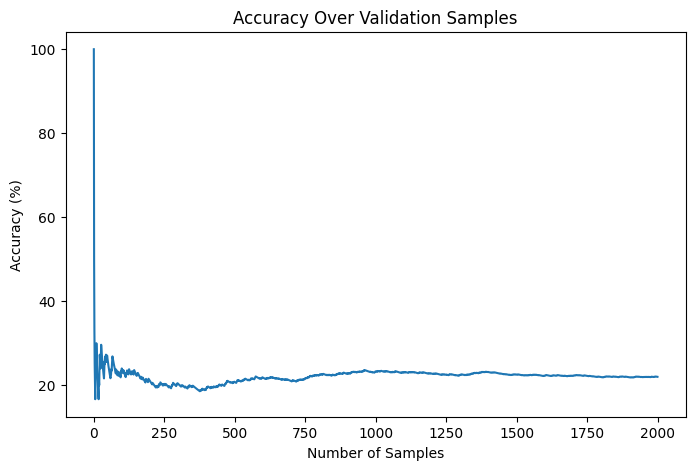

In [ ]:
accuracies = np.cumsum(np.array(all_labels) == np.array(all_preds)) / np.arange(1, len(all_labels) + 1)
plt.figure(figsize=(8, 5))
plt.plot(accuracies * 100)
plt.title("Accuracy Over Validation Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Accuracy (%)")